# **Vehicle Detection for Autonomous Cars** 
***

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Test Images

Built my pipeline to work on the images in the directory "test_images"

In [2]:
import os

# print test images file name
test_images_names = os.listdir("test_images/")
print(test_images_names)

['feature-extraction', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


### Read in the Test Image
I'll test each step of my pipeline on the following test image

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


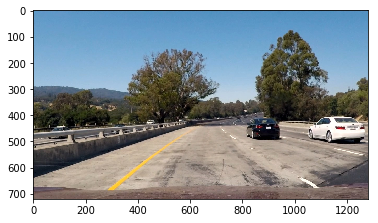

In [3]:
#reading in a test image
test_image = mpimg.imread('test_images/test1.jpg')

# printing out some stats and plotting
print('This image is:', type(test_image), 'with dimesions:', test_image.shape)
plt.imshow(test_image) 

### Draw Boxes Manually to Prototype
This function takes an image, a list of bounding boxes, and optional color tuple and line thickness as inputs and then draws boxes in that color on the output

In [4]:
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
            cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img 

Test drawing boxes on the test image

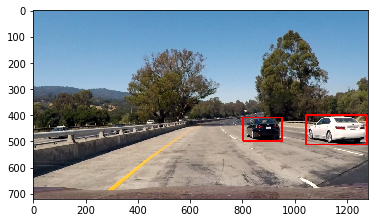

In [5]:
# manually set the coordinates of the vehicule boxes 
bboxes = [((951, 498), (803, 409)), ((1276, 512), (1043, 401))]

result = draw_boxes(test_image, bboxes)
plt.imshow(result)

## Vehicle Feature Extraction

Test Feature Extraction on this test vehicle image

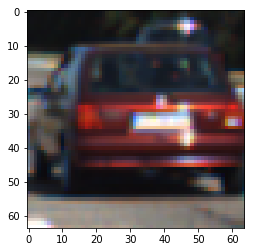

In [6]:
#reading in a vehicle test image
test_vehicle_image = mpimg.imread('test_images/feature-extraction/7.png')
plt.imshow(test_vehicle_image) 

### Histogram-of-Colors Feature Extraction

This function extracts histogram-of-colors features

In [7]:
def get_hoc_features(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

Plot Histogram of Color-Space feature extraction of Test Image

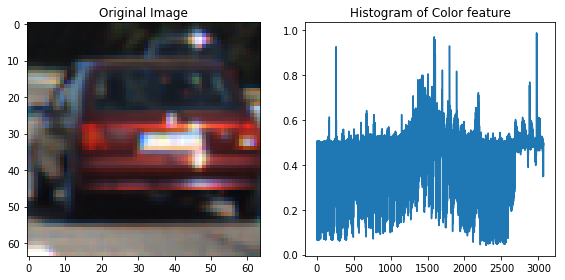

In [9]:
# Define HOC parameters
test_color_space='YCrCb'
test_size = (32,32)

test_features_color = get_hoc_features(test_vehicle_image, test_color_space, test_size)

# Plot an example of raw and gradient features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_vehicle_image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(test_features_color)
plt.title('Histogram of Color feature')
fig.tight_layout()

### Histogram-of-Gradients Feature Extraction
This function takes in a vehicle image and returns a Histogram of Gradients feature vector

In [10]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=False, feature_vector=feature_vec)
        return features

Test the Histogram of Gradient feature extraction on a test image and Visualize HOG Image

C:\Users\Vincent\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


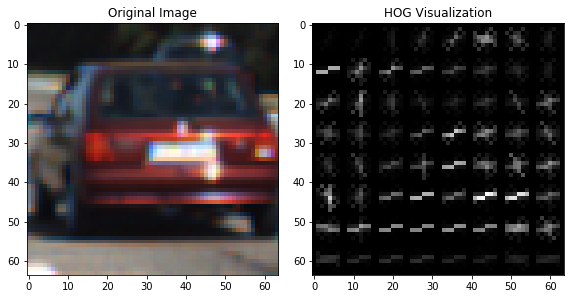

In [11]:
# Convert image to grayscale
test_gray = cv2.cvtColor(test_vehicle_image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
test_orient = 9
test_pix_per_cell = 8
test_cell_per_block = 2
# Call our function with vis=True to see an image output
test_features_gradient, hog_image = get_hog_features(test_gray, test_orient, 
                        test_pix_per_cell, test_cell_per_block, 
                        vis=True, feature_vec=False)

# Plot an example of raw and HOG Image
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_vehicle_image, cmap='gray')
plt.title('Original Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
fig.tight_layout()

Plot Histogram of Gradient feature extraction

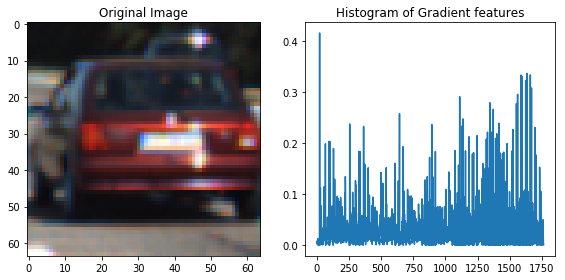

In [12]:
test_features_gradient = test_features_gradient.ravel() 

# Plot an example of raw and gradient features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_vehicle_image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(test_features_gradient)
plt.title('Histogram of Gradient features')
fig.tight_layout()

### Combine and Normalize Color and Gradient Features

This function combines and normalizes the extracted Histogram-of-Color and Histogram-of-Gradient features

In [13]:
from sklearn.preprocessing import StandardScaler

def combine_normalize_features(img, color_space, size, gray, orient, pix_per_cell, cell_per_block):
    features_color = get_hoc_features(img, color_space, size)
    features_gradient = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    
    # Create a list of feature vectors
    feature_list = np.concatenate((features_color, features_gradient))
    
    # Create an array stack, NOTE: StandardScaler() expects np.float64
    X = np.vstack(feature_list).astype(np.float64)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    return scaled_X

Test combining and normalizing Color and Gradient Features

C:\Users\Vincent\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


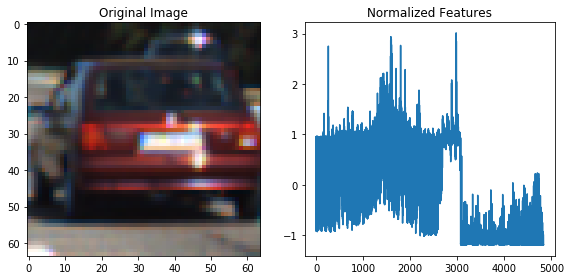

In [14]:
test_features_combined_normalized = combine_normalize_features(test_vehicle_image, test_color_space, test_size, 
                             test_gray, test_orient, test_pix_per_cell, test_cell_per_block)

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_vehicle_image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(test_features_combined_normalized)
plt.title('Normalized Features')
fig.tight_layout()